<a href="https://colab.research.google.com/github/jeffheaton/app_deep_learning/blob/main/t81_558_class_05_5_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-558: Applications of Deep Neural Networks
**Module 6: Convolutional Neural Networks (CNN) for Computer Vision**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 5 Material

- Part 5.1: Image Processing in Python [[Video]](https://www.youtube.com/watch?v=Sob7VDb4xh8&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_05_1_python_images.ipynb)
- Part 5.2: Using Convolutional Neural Networks [[Video]](https://www.youtube.com/watch?v=jL0_lOpEwSk&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_05_2_cnn.ipynb)
- Part 5.3: Using Pretrained Neural Networks[[Video]](https://www.youtube.com/watch?v=W2T-dfiHYSo&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_05_3_vision_transfer.ipynb)
- Part 5.4: Looking at Generators and Image Augmentation [[Video]](https://www.youtube.com/watch?v=20JoEmQb810&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_05_4_generators.ipynb)
- **Part 5.5: Recognizing Multiple Images with YOLOv5** [[Video]](https://www.youtube.com/watch?v=7Uu1n9Tp0Mk&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_05_5_yolo.ipynb)

# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.
  Running the following code will map your GDrive to ```/content/drive```.

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


# Part 5.5: Recognizing Multiple Images with YOLO

Programmers typically design convolutional neural networks to classify a single item centered in an image. However, as humans, we can recognize many items in our field of view in real-time. It is advantageous to recognize multiple items in a single image. One of the most advanced means of doing this is YOLO. You Only Look Once (YOLO) was introduced by Joseph Redmon, who supported YOLO up through V3. [[Cite:redmon2016you]](https://arxiv.org/abs/1506.02640) The fact that YOLO must only look once speaks to the efficiency of the algorithm. In this context, to "look" means to perform one scan over the image. It is also possible to run YOLO on live video streams.


Joseph Redmon became less involved in YOLO after v3. The later versions, after YOLOv5 are supported by the startup company [Ultralytics](https://ultralytics.com/), who released the open-source library that we use in this class.[[Cite:zhu2021tph]](https://arxiv.org/abs/2108.11539)

Researchers have trained YOLO on a variety of different computer image datasets. The version of YOLO weights used in this course is from the dataset Common Objects in Context (COCO). [[Cite: lin2014microsoft]](https://arxiv.org/abs/1405.0312) This dataset contains images labeled into 80 different classes. COCO is the source of the file coco.txt used in this module.

## Using YOLO in Python

To use YOLO in Python, we will use the open-source library provided by Ultralytics.

* [YOLO Ultralytics GitHub](https://github.com/ultralytics/ultralytics)
* [YOLO Documentation](https://docs.ultralytics.com/)

The code provided in this notebook works equally well when run either locally or from Google CoLab. It is easier to run YOLO from CoLab, which is recommended for this course.

We begin by obtaining an image to classify.


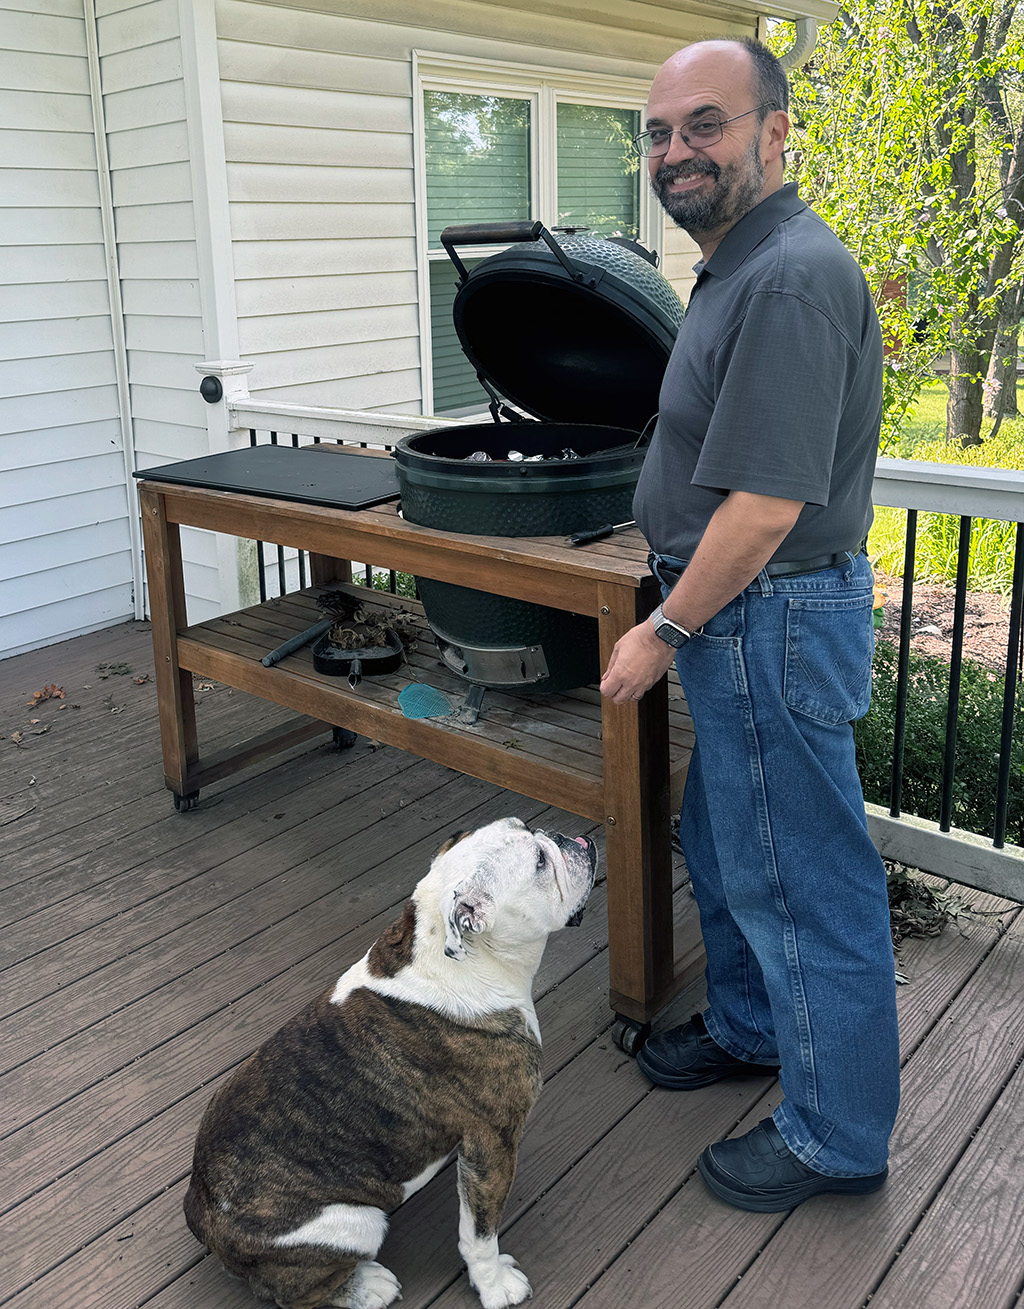

In [2]:
import urllib.request
import shutil
from IPython.display import Image
!mkdir /content/images/

URL = "https://data.heatonresearch.com/images/wustl/photos/jeff_cook2.jpg"
LOCAL_IMG_FILE = "/content/images/jeff_cook2.jpg"

with urllib.request.urlopen(URL) as response, \
  open(LOCAL_IMG_FILE, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

Image(filename=LOCAL_IMG_FILE, width=320)

## Installing YOLO

YOLO is now available directly through PIP. The following commands install YOLO with PIP.

In [3]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

Next, we will run YOLO from the command line and classify the previously downloaded kitchen picture.  You can run this classification on any image you choose.

In [4]:
!yolo predict model=yolov8n-seg.pt source=$LOCAL_IMG_FILE imgsz=320

100% 6.74M/6.74M [00:00<00:00, 108MB/s]
Ultralytics YOLOv8.2.74 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-seg summary (fused): 195 layers, 3,404,320 parameters, 0 gradients, 12.6 GFLOPs

image 1/1 /content/images/jeff_cook2.jpg: 320x256 1 person, 1 dog, 1 bowl, 100.8ms
Speed: 12.2ms preprocess, 100.8ms inference, 717.6ms postprocess per image at shape (1, 3, 320, 256)
Results saved to runs/segment/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


	You will see that there are several parameters that you can specify:
  
  * **imgsz** - Defines the image size for inference. Can be a single integer 640 for square resizing or a (height, width) tuple. Proper sizing can improve detection accuracy and processing speed. default=640
  * **iou** - Intersection Over Union (IoU) threshold for Non-Maximum Suppression (NMS). Lower values result in fewer detections by eliminating overlapping boxes, useful for reducing duplicates. default=0.7
  * **conf** = Sets the minimum confidence threshold for detections. Objects detected with confidence below this threshold will be disregarded. Adjusting this value can help reduce false positives. default=0.25

In [5]:
!ls ./runs/segment/predict/

jeff_cook2.jpg


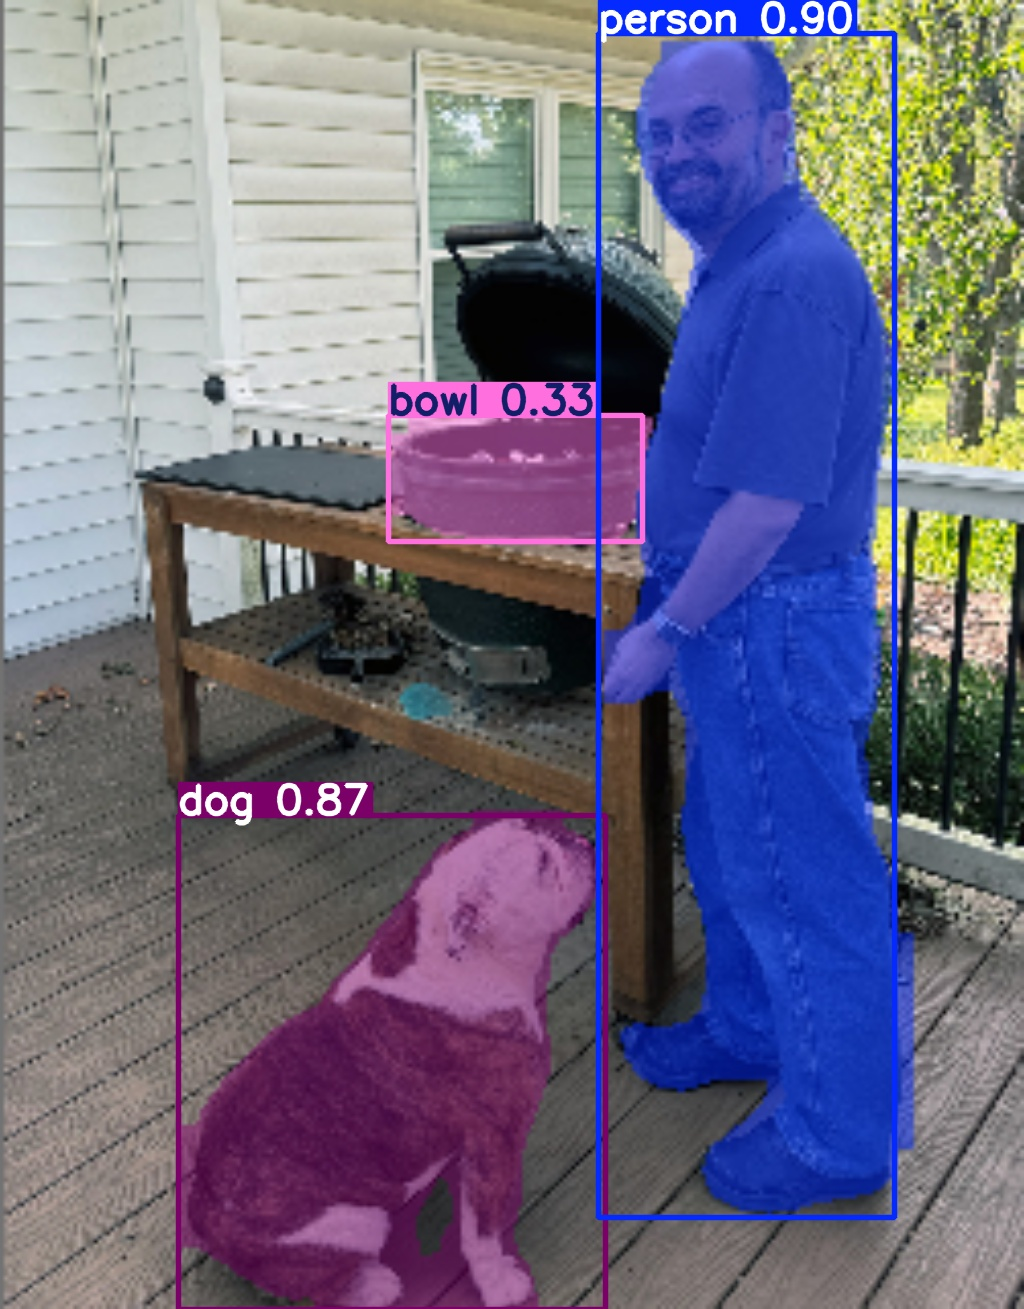

In [6]:
# Display the images
from IPython.display import Image

file = './runs/segment/predict/jeff_cook2.jpg'
Image(filename=file, width=300)

## Running YOLO from Python

In addition to the command line execution, we can also make use of YOLO right in Python code.

In [7]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Use the model
results = model(LOCAL_IMG_FILE, iou=0.7, conf=0.25)  # predict on an image

100%|██████████| 6.25M/6.25M [00:00<00:00, 103MB/s]



image 1/1 /content/images/jeff_cook2.jpg: 640x512 1 person, 1 dog, 1 bowl, 164.1ms
Speed: 28.9ms preprocess, 164.1ms inference, 955.2ms postprocess per image at shape (1, 3, 640, 512)


We will look at some of the information returned by the model. First we can get a list of all items it can recognize.

In [8]:
print("Classes supported")
print(results[0].names)

Classes supported
{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell p

We can also see the classes detected here.

In [9]:
results[0].boxes.cls

tensor([16.,  0., 45.], device='cuda:0')

It can be useful to group everything detected into a Pandas dataframe.

In [10]:
import pandas as pd

def results_to_dataframe(results):
    lookup = results[0].names
    boxes = results[0].boxes

    data = {
        'class': [int(item) for item in boxes.cls],
        'name': [lookup[int(item)] for item in boxes.cls],
        'xmin': [int(box[0]) for box in boxes.xyxy],
        'ymin': [int(box[1]) for box in boxes.xyxy],
        'xmax': [int(box[2]) for box in boxes.xyxy],
        'ymax': [int(box[3]) for box in boxes.xyxy],
    }

    return pd.DataFrame(data)


df = results_to_dataframe(results)
df

,class,name,xmin,ymin,xmax,ymax
0,16,dog,182,816,599,1308
1,0,person,595,41,903,1217
2,45,bowl,388,417,646,542
